In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('./data/')
sys.path.append('./models/')

In [2]:
from baseline import *
import pickle
with open('./data/dict_data_final.pkl', 'rb') as f:
    data = pickle.load(f)

# Datos reales $(x,y)$

In [3]:
x, y = data['Beneixama']

# Parámetros

In [4]:
list_P = [
    [0, 0.1, 0.5, 0.9, 1.01],
    [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.01],
]
list_C = [1, 1.5, 2, 2.5, 3]

# Funciones

# Resultados

In [5]:
P = list_P[1]
C = list_C[2]

In [6]:
grid = Grid(x=x, y=y)
grid.initialize(part=P, div=C)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

In [7]:
grid_g = Grid(x=x, y=y, mode='gumbel')
grid_g.initialize(part=P, div=C)
grid_g.submatrix()
grid_g.enlargement_process()
grid_g.montecarlo(n_it=100)

In [8]:
sus_X = [(grid.X[:, :, i] == 0).sum().item() for i in range(grid.X.shape[2])]
sus_y = [(grid.y[:, :, i] == 0).sum().item() for i in range(grid.y.shape[2])]
abs_X = range(len(sus_X))
abs_y = np.argwhere(x.Train.values == True).flatten()

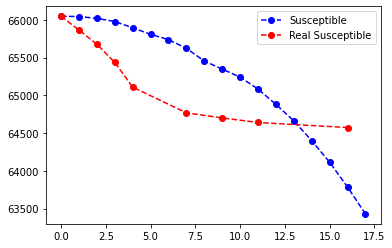

In [9]:
#plt.plot(grid.df_MC['Susceptible'], label='Exp. Susceptible')
plt.plot(abs_X, sus_X, 'b--o', label='Susceptible')
plt.plot(abs_y, sus_y, 'r--o', label='Real Susceptible')
plt.legend()
plt.show()

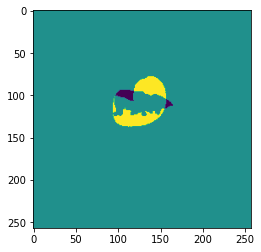

In [10]:
from sklearn.metrics import confusion_matrix

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)

<AxesSubplot:>

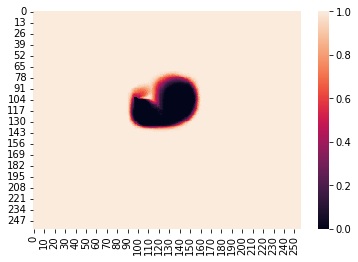

In [11]:
sns.heatmap(grid.X0[:, :, -1])

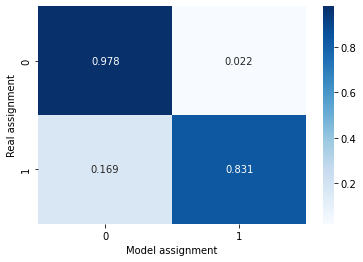

In [60]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, matthews_corrcoef

# compute the confusion matrix of X e Y

cmat = confusion_matrix(Y.flatten(), X.flatten(), normalize='true')
total = np.sum(cmat)
sns.heatmap(cmat, annot=True, cmap='Blues', fmt='.3f')
plt.xlabel('Model assignment')
plt.ylabel('Real assignment')
plt.show()

In [61]:
cmat

array([[0.97842752, 0.02157248],
       [0.16869919, 0.83130081]])

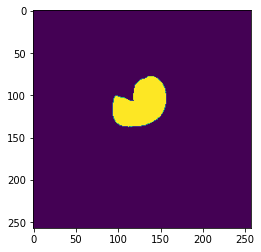

In [58]:
plt.imshow(X)

In [51]:
f1_score(Y.flatten(), X.flatten()), accuracy_score(Y.flatten(), X.flatten()), matthews_corrcoef(Y.flatten(), X.flatten())

(0.59912109375, 0.9751396690335963, 0.6132159132568697)

In [33]:
(cmat[0,0] + cmat[1,1])/(cmat.sum())

0.9048641645763243

In [21]:
grid = Grid(x=x, y=y)
grid.initialize(part=P, div=C)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

In [22]:
grid_g = Grid(x=x, y=y, mode='gumbel')
grid_g.initialize(part=P, div=C)
grid_g.submatrix()
grid_g.enlargement_process()
grid_g.montecarlo(n_it=100)

In [23]:
df_resta = abs(grid_g.df_MC - grid.df_MC)

<AxesSubplot:>

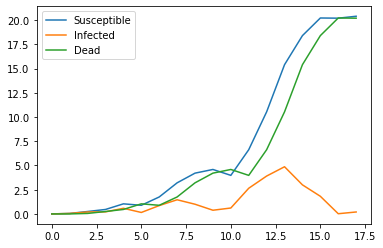

In [24]:
df_resta.plot()

# CREAMOS LA TABLA DE RESULTADOS PARA EL MODELO BASELINE en función de $(\mathcal{P}, C)$

In [37]:
list_P = [
    [0, 0.1, 0.5, 0.9, 1.01],
    [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.01],
]
list_C = [1, 2, 3]

In [65]:
def CreateTable(x, y, list_P, list_C, mode='bernoulli'):
    
    from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, matthews_corrcoef

    columns = ['FP rate', 'FN rate', 'Accuracy', 'F1-score', 'MCC']
    size_rows = len(list_P) * len(list_C)
    size_cols = len(columns) 
    df = pd.DataFrame(np.zeros((size_rows, size_cols)), columns=columns)

    ind = 0
    for p in list_P:
        for C in list_C:

            grid = Grid(x=x, y=y, mode=mode)
            grid.initialize(part=p, div=C)
            grid.submatrix()
            grid.enlargement_process()
            grid.montecarlo(n_it=100)

            X = (grid.X[:, :, -1].numpy() != 0)*1
            Y = (y[:, :, -1] != 0)*1

            cmat = confusion_matrix(Y.flatten(), X.flatten(), normalize='true')

            df.iloc[ind] = [cmat[0,1], cmat[1,0], accuracy_score(Y.flatten(), X.flatten()), f1_score(Y.flatten(), X.flatten()), matthews_corrcoef(Y.flatten(), X.flatten())]
            ind += 1
    df['Sum metrics'] = df['Accuracy'] + df['F1-score'] + df['MCC']

    return df

In [66]:
df_metrics = CreateTable(x, y, list_P, list_C)

In [75]:
df_metrics.columns.values[:2] = ['FP rate', 'FN rate']
df_metrics

,FP rate,FN rate,Accuracy,F1-score,MCC
0,0.006380,0.400407,0.984814,0.638298,0.631950
1,0.003934,0.439024,0.986343,0.647381,0.648629
2,0.001146,0.578591,0.985950,0.572744,0.608349
3,0.046846,0.205962,0.949598,0.413185,0.452746
4,0.021572,0.168699,0.975140,0.599121,0.613216
5,0.005157,0.411247,0.985768,0.648992,0.645333
6,0.208601,0.150407,0.792699,0.154815,0.227638
7,0.062240,0.090108,0.937138,0.392805,0.458749
8,0.008022,0.329946,0.984784,0.663091,0.655345


In [76]:
df_metrics['Sum metrics'] = df_metrics['Accuracy'] + df_metrics['F1-score'] + df_metrics['MCC']
df_metrics

,FP rate,FN rate,Accuracy,F1-score,MCC,Sum metrics
0,0.006380,0.400407,0.984814,0.638298,0.631950,2.255062
1,0.003934,0.439024,0.986343,0.647381,0.648629,2.282354
2,0.001146,0.578591,0.985950,0.572744,0.608349,2.167043
3,0.046846,0.205962,0.949598,0.413185,0.452746,1.815529
4,0.021572,0.168699,0.975140,0.599121,0.613216,2.187477
5,0.005157,0.411247,0.985768,0.648992,0.645333,2.280093
6,0.208601,0.150407,0.792699,0.154815,0.227638,1.175152
7,0.062240,0.090108,0.937138,0.392805,0.458749,1.788691
8,0.008022,0.329946,0.984784,0.663091,0.655345,2.303220


In [77]:
df_metrics.to_csv('baseline_metrics.csv')

In [91]:
df_metrics['MCC'].values.max()

0.6553449925191407

# Figuras de los mejores resultados

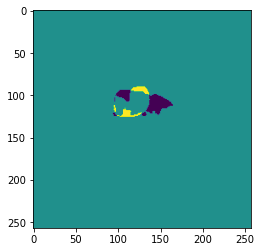

In [78]:
grid = Grid(x=x, y=y)
grid.initialize(part=list_P[0], div=list_C[1])
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)

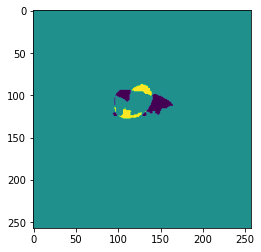

In [79]:
grid = Grid(x=x, y=y)
grid.initialize(part=list_P[1], div=list_C[2])
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)

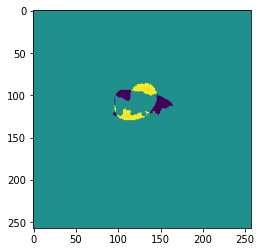

In [80]:
grid = Grid(x=x, y=y)
grid.initialize(part=list_P[-1], div=list_C[-1])
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)

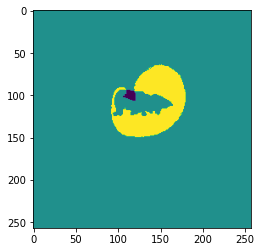

In [81]:
grid = Grid(x=x, y=y)
grid.initialize(part=list_P[-1], div=list_C[1])
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)